# Scenario assessment for 115 wind assets:


## Coverage

In this section, we will create a variety of plots and numerical indicators of how well the scenarios cover the actuals on an hourly and daily basis. Using windPercentiles we plot PIT histograms and coverage heatmaps.

### Zonal / State Level
First, we must take in percentiles on 6-hours chunk in the Intraday scenario folder, which were generated by Glen's data directly from the Scoville server. These are currently done on a zonal level, but in principle, we can do them on a cluster level as well. We would need to re-run the percentile analysis with cluster level aggregation, in that case. We could also run this on an individual asset level fairly easily; discuss with Mike if this makes sense to do. 

Next, we will create a function which can calculate daily coverage. We say a day is covered for a particular asset type if there is at most one hour throughout the day where the aggregated actual for said asset lies outside all of the aggregated scenarios for said asset type.

In [2]:
# some global variables that will be useful for us
start_date = "20170101"
end_date = "20181231"
end_date_specific = "20181230 23:00:00" # These dates should change to fit your needs
# in general, datetime objects might not work as well as they did in the day ahead case

date_times_hrs = pd.date_range(start=start_date, end=end_date_specific, freq="H")
date_times_days = pd.date_range(start=start_date, end=end_date, freq="D")
zones = ['FW', 'N', 'NC', 'S', 'W']
#zones = ['Coast', 'East', 'Far_West', 'North', 'North_Central', 'South', 'South_Central', 'West']

def get_daily_coverage(filenames, days, hours, src="Scoville"):
    daily_coverage_all = []
    count = 0
    for name in filenames:
        # read in files and make the dates correspond to datetimes
        hourly_percentiles = pd.read_csv(name)
        hourly_percentiles = hourly_percentiles[((hourly_percentiles['Date'] >= start_date) &
                                  (hourly_percentiles['Date'] <= end_date))]
        hourly_percentiles['Date'] = hours
        hourly_percentiles = hourly_percentiles.set_index('Date')
        # get daily coverage - we say a day is covered if there is at most 1 hour where
        # the actuals are outside the range of the scenarios
        # iterate across days and select only the hours that are relevant to determine daily coverage
        if src == "Scoville":
            daily_coverage_mat = np.zeros((len(days), 1))
        for i in np.arange(len(days)):
            # make sure we dont get an index out of bounds error
            if i == len(days)-1:
                c0 = hourly_percentiles.index.to_series().between(days[i], days[i] + pd.Timedelta(hours=23))
            else:
                c0 = hourly_percentiles.index.to_series().between(days[i], days[i+1] - pd.Timedelta(hours=1))
            # check if hourly_percentiles is 0 or 100, sum up across rows, and check that there is more than 1 hour offendinf
            daily_coverage_mat[i,:] = (np.sum((hourly_percentiles[c0] == 100) | (hourly_percentiles[c0] == 0),
                                              axis=0)) <= 1
        # hard-coded in for now; not sure if there's a better way - this will have to change at each level of aggregation
        if src =="Scoville":
            area = name[134:-4] # this is hardcoded based on my file names - this should definitely change for you
            daily_coverage = pd.DataFrame(daily_coverage_mat, columns = [zones[count]], index = date_times_days)
            # it is extremely lucky that this works for both princeton and scoville currently... maybe have to change this
        # going forward            
        daily_coverage_all.append(daily_coverage)
        count += 1
  
    daily_coverage_all = pd.concat(daily_coverage_all, axis=1) 
    return daily_coverage_all

daily_coverage_new_zonal = get_daily_coverage(file_names_new_zonal, date_times_days, date_times_hrs)


In [3]:
# We want to do the same thing at the asset level
def get_daily_coverage_asset_lvl(filenames, days, hours, src="Scoville"):
    daily_coverage_all = []
    for name in filenames:
        #hourly_percentiles = pd.read_csv(name, index_col=0)
        hourly_percentiles = pd.read_csv(name)
        hourly_percentiles = hourly_percentiles[((hourly_percentiles['Date'] >= start_date) &
                                  (hourly_percentiles['Date'] <= end_date))]

        # ignoring the filtering for now, since we're in a time crunch - can fix this later 
        print('hours',hours.shape)
        print('hourly percentile',hourly_percentiles['Date'].shape)
        hourly_percentiles['Date'] = hours
        hourly_percentiles = hourly_percentiles.set_index('Date')        
        daily_coverage_mat = np.zeros((len(days), hourly_percentiles.shape[1]))
        for i in np.arange(len(days)):
            # make sure we dont get an index out of bounds error
            if i == len(days)-1:
                c0 = hourly_percentiles.index.to_series().between(days[i], days[i] + pd.Timedelta(hours=23))
            else:
                c0 = hourly_percentiles.index.to_series().between(days[i], days[i+1] - pd.Timedelta(hours=1))
            # check if hourly_percentiles is 0 or 100, sum up across rows, and check that there is more than 1 hour offendinf
            daily_coverage_mat[i,:] = (np.sum((hourly_percentiles[c0] == 0),
                                              axis=0)) <= 1 # We care about covering from below, so we only want to identify 0s, not 100s (hourly_percentiles[c0] == 100) | 
        daily_coverage = pd.DataFrame(daily_coverage_mat, columns = hourly_percentiles.columns, index=date_times_days)
        #print(daily_coverage)
        daily_coverage_all.append(daily_coverage)
    wind_coverage_by_asset = daily_coverage_all[0]
    return wind_coverage_by_asset

wind_coverage_by_asset = get_daily_coverage_asset_lvl(file_names_new_asset, date_times_days, date_times_hrs)



hours (17496,)
hourly percentile (17496,)


After creating the files which tell us the daily coverage at each level of aggregation, we must either plot or summarize the results numerically. The code block below plots all the daily coverages in a heat map.

Now we will focus on the asset level and produce daily coverage at the asset level (across asset types) and report the daily % of assets which cover. 

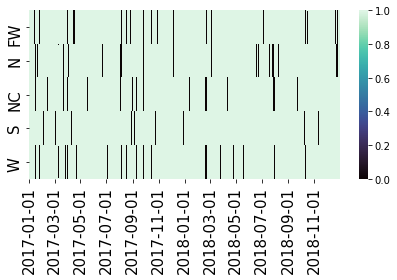

In [14]:
# the first few functions here were copied from elsewhere online, in order to get the axes labels the way I wanted 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Iterable
from sklearn import linear_model

class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

def plot_heat_map(df, title=None):
    plt.figure()
    ax = sns.heatmap(df.transpose(), cmap="mako", yticklabels=True)
    ax.tick_params(labelsize=15)
    set_date_ticks(ax, '2017-01-01', '2018-12-31', freq='2MS', axis='x')
    w = ax.get_xticks()
    h = ax.get_yticks()
    for i in np.arange(int(len(h)/3))[1:]:
        ax.hlines((h[3*i] + h[3*i-1])/2,w[0]+0.5, w[-1]+500.5,linestyle='dashed', linewidth=2, color="white")
    if title:
        ax.set_title(title)
    
plot_heat_map(daily_coverage_new_zonal)
#plt.title("Coverage of ORFEUS Model (Zonal)")
plt.tight_layout()
#plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output\\Percentiles\\DASolar\\Figures\\CoverageofORFEUSModelDASolar.png", dpi=300)
plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output2\\Percentiles\\CoverageofORFEUSModelDAWindV2Subset.png", dpi=300)




In [5]:
# can do this based on 0s or 100s or both - maybe use this in the diagnostics as well

wind_daily_coverage_asset_lvl_mean_by_days = np.mean(wind_coverage_by_asset, axis=1)


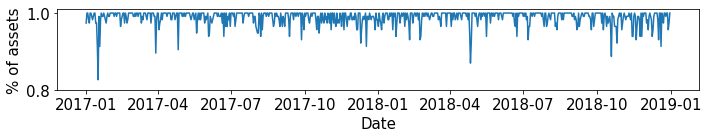

In [6]:
from pandas.plotting import register_matplotlib_converters
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1,1,1)
ax.plot(wind_daily_coverage_asset_lvl_mean_by_days)
ax.tick_params(labelsize=15)
plt.ylim([0.8, 1.01])
plt.xlabel("Date",fontsize=15)
plt.ylabel("% of assets",fontsize=15)
#plt.title("Wind Coverage From Below at Asset Level Across Time (ORFEUS)")
plt.tight_layout()
#plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output\\Percentiles\\DASolar\\Figures\\WindCoverageDASolar.png", dpi=300)


Text(0, 0.5, 'Count')

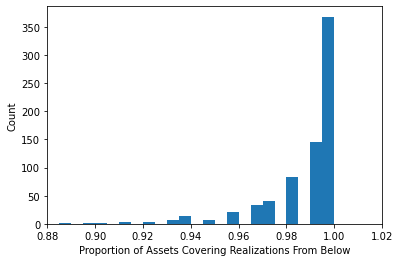

In [7]:
bars = np.linspace(0.88,1,25)
# print(bars)
# plt.figure()
# plt.hist(load_daily_coverage_asset_lvl_mean_by_days, bars)
plt.figure()
plt.hist(wind_daily_coverage_asset_lvl_mean_by_days, bars)
plt.xlim([0.88, 1.02])
plt.xlabel("Proportion of Assets Covering Realizations From Below")
plt.ylabel("Count")
#plt.title("Histogram of Solar Coverage From Below at Asset Level (ORFEUS)")
#plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output\\Percentiles\\DASolar\\Figures\\HistogramCoverageDASolar.png", dpi=300)

In [8]:
# histogram of percentiles at the asset level

def get_hourly_percentiles_asset_level(filenames, src="Scoville"):
    percentile_all = []
    for name in filenames:
        # read in files and make the dates correspond to datetimes
        hourly_percentiles = pd.read_csv(name, index_col=0)
        #print(hourly_percentiles.head)
        #hourly_percentiles=hourly_percentiles.set_index('Date', inplace = True)
        percentile_all.append(hourly_percentiles)
    percentile_all = pd.concat(percentile_all, axis=1)
    return percentile_all
asset_level_percentiles_scoville = get_hourly_percentiles_asset_level(file_names_new_asset, src="Scoville")

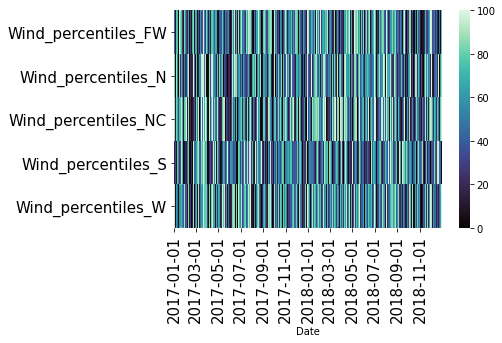

In [9]:
def get_hourly_percentiles(filenames, hours, src="Scoville"):
    percentile_all = []
    count = 0
    for name in filenames:
        # read in files and make the dates correspond to datetimes
        hourly_percentiles = pd.read_csv(name)
        hourly_percentiles = hourly_percentiles[((hourly_percentiles['Date'] >= start_date) &
                                  (hourly_percentiles['Date'] <= end_date))]
        hourly_percentiles['Date'] = hours
        hourly_percentiles = hourly_percentiles.set_index('Date')
        if src == "Scoville":
            area = zones[count]
            hourly_percentiles.columns = ['Wind_percentiles_'+area]

        percentile_all.append(hourly_percentiles)
        count+=1
    percentile_all = pd.concat(percentile_all, axis=1)
    return percentile_all

hourly_percentiles_new_zonal = get_hourly_percentiles(file_names_new_zonal, date_times_hrs)
#print(hourly_percentiles_new_zonal)
plot_heat_map(hourly_percentiles_new_zonal)
#plt.savefig("test.png", dpi=1200) # note that the above doesn't look very good in Jupyter due to file compression


Now that we have daily coverage, we should also consider a couple other ways to use these percentiles; however, we want the ability to be a little more granular. Therefore, we will also consider another method of analysis with percentiles:
* Hourly percentiles (heatmap only)


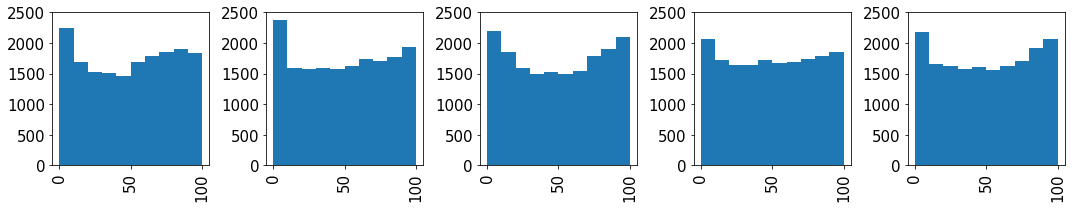

In [10]:
# Plot grid of histograms, and of moving average, as the above can be difficult to interpret
# hourly_percentiles_new_zonal.hist(figsize=(15, 20),layout=(8,3))
# plt.savefig("percentiles_histogram.png", dpi=300)
# plt.show()

def separate_asset(df, asset):
    # simple helper function to separate the columns with baselines from the dfs which store the ES
    df = df[list(df.filter(regex=asset))]
    return df

wind_only_new_zonal = separate_asset(hourly_percentiles_new_zonal, 'Wind')
fig = plt.figure(figsize=(15,3))

ax = fig.add_subplot(1,5,1)
ax.tick_params(labelsize=15)
ax.set_ylim([0, 2500])
ax.hist(wind_only_new_zonal.iloc[:,0], bins=10)
plt.xticks(rotation=90)

ax = fig.add_subplot(1,5,2)
ax.tick_params(labelsize=15)
ax.set_ylim([0, 2500])
ax.hist(wind_only_new_zonal.iloc[:,1], bins=10)
plt.xticks(rotation=90)

ax = fig.add_subplot(1,5,3)
ax.tick_params(labelsize=15)
ax.set_ylim([0, 2500])
ax.hist(wind_only_new_zonal.iloc[:,2], bins=10)
plt.xticks(rotation=90)

ax = fig.add_subplot(1,5,4)
ax.tick_params(labelsize=15)
ax.set_ylim([0, 2500])
ax.hist(wind_only_new_zonal.iloc[:,3], bins=10)
plt.xticks(rotation=90)

ax = fig.add_subplot(1,5,5)
ax.tick_params(labelsize=15)
ax.set_ylim([0, 2500])
ax.hist(wind_only_new_zonal.iloc[:,4], bins=10)
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output\\Percentiles\\DASolar\\Figures\\WindHistogramDASolar.png", dpi=300)


# this code block might produce a warning for solars, but it's not one we need to worry about, since Python is just warning about the NaNs


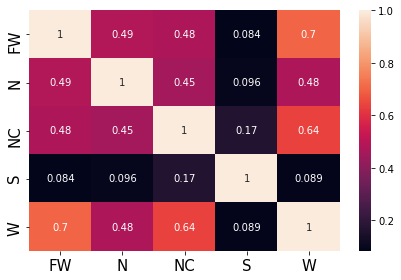

In [11]:
plt.figure()
ax=sns.heatmap(np.corrcoef(wind_only_new_zonal, rowvar=False),annot=True,  xticklabels=zones,
           yticklabels = zones)
ax.tick_params(labelsize=15)
#plt.title("Correlation of wind percentiles across zones")
plt.tight_layout()
#plt.savefig("C:\\Users\\Mahashweta Patra\\Documents\\MikeLudkovski\\Output\\Percentiles\\DASolar\\Figures\\CorrelationHeatmapDASolar.png", dpi=300)


In [15]:
from IPython.display import Image
Image(url= "v1v2EnergyScoreWind.png" , width=400, height=400)

In [16]:
from IPython.display import Image
Image(url= "EnergyScoreWindVersion2.png" , width=400, height=400)

In [23]:
from IPython.display import Image
Image(url= "EnergyScoreZonalWind.png" , width=600, height=500)

In [21]:
from IPython.display import Image
Image(url= "HistogramKSscoreVersion2.png" , width=700, height=500)

In [17]:
from IPython.display import Image
Image(url= "v1v2wind.png" , width=400, height=400)

### Takeaway

1. Same as the previous version East, Coast, South Central zones do not have a percentile and energy score. Wind energy score is zero for these three zones.
2. In the heatmap plots, like the version 1, south zone has least correlation with other zones. The correlation coefficient are of lower magnitude than the version 1. 
3. KS scores for the five zones are:  0.0297, 0.0376, 0.0341, 0.0209, 0.0287 
4. KS score for the aggregated assets are: 0.041559
   which are lower than the version 1